# Recognition of Yoga Postures

## Necessary libraries
We choose
[Tensorflow](https://pytorch.org/)
as our framework for this project for its learning parh and It is Simple GPU installation.
And we are going to work with

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import shutil
import numpy as np
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report
from shutil import copyfile
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
from utils import split_data
from fastai.vision.all import get_image_files,verify_images
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.losses import categorical_crossentropy,SparseCategoricalCrossentropy
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import datetime
from tensorflow.keras.utils import plot_model


In [2]:
# check if CUDA is available to use GPU on the training 
train_on_gpu = tf.config.list_physical_devices('GPU')
if train_on_gpu:
    print('GPU con soporte CUDA disponible')
else:
    print('No se encontró GPU con soporte CUDA')

GPU con soporte CUDA disponible


We r going to delet images "broken"

In [4]:
images=get_image_files('../YOGA/data')
images
failed = verify_images(images)
failed

(#0) []

In [5]:
# Define paths for the images
downdog_SRC_DIR = "data/downdog"
plank_SRC_DIR = "data/plank"
tree_SRC_DIR = "data/tree"
warrior_SRC_DIR = "data/warrior"
TRAINING_DIR = "dataset/training"
VALIDATION_DIR = "dataset/validation"
TEST_DIR = "dataset/test"
#splitting the dataset
TRAINING_DDG_DIR = os.path.join(TRAINING_DIR, "downdog/")
VALIDATION_DDG_DIR = os.path.join(VALIDATION_DIR, "downdog/")
TEST_DDG_DIR = os.path.join(TEST_DIR, "downdog/")

TRAINING_PLANK_DIR = os.path.join(TRAINING_DIR, "plank/")
VALIDATION_PLANK_DIR = os.path.join(VALIDATION_DIR, "plank/")
TEST_PLANK_DIR = os.path.join(TEST_DIR, "plank/")

TRAINING_TREE_DIR = os.path.join(TRAINING_DIR, "tree/")
VALIDATION_TREE_DIR = os.path.join(VALIDATION_DIR, "tree/")
TEST_TREE_DIR = os.path.join(TEST_DIR, "tree/")

TRAINING_WR_DIR = os.path.join(TRAINING_DIR, "warrior/")
VALIDATION_WR_DIR = os.path.join(VALIDATION_DIR, "warrior/")
TEST_WR_DIR = os.path.join(TEST_DIR, "warrior/")
# Define proportion of images used for training
train_size = 0.8
val_size = 0.1
test_size = 0.1

split_data(downdog_SRC_DIR,
           TRAINING_DDG_DIR,
           VALIDATION_DDG_DIR,
           TEST_DDG_DIR,
           split_ratio=(train_size,val_size, test_size))

split_data(plank_SRC_DIR,
           TRAINING_PLANK_DIR,
           VALIDATION_PLANK_DIR,
           TEST_PLANK_DIR,
           split_ratio=(train_size,val_size, test_size))

split_data(tree_SRC_DIR,
           TRAINING_TREE_DIR,
           VALIDATION_TREE_DIR,
           TEST_TREE_DIR,
           split_ratio=(train_size,val_size, test_size))
split_data(warrior_SRC_DIR,
           TRAINING_WR_DIR,
           VALIDATION_WR_DIR,
           TEST_WR_DIR,
           split_ratio=(train_size,val_size, test_size))

Splitting data completed.
Splitting data completed.
Splitting data completed.
Splitting data completed.


In [6]:
print(f"Original Downdog directory has {len(os.listdir(downdog_SRC_DIR))} images")
print(f"Original Plank directory has {len(os.listdir(plank_SRC_DIR))} images")
print(f"Original Tree directory has {len(os.listdir(tree_SRC_DIR))} images")
print(f"Original Warrior directory has {len(os.listdir(warrior_SRC_DIR))} images\n")

# Training and validation splits
print(f"There are {len(os.listdir(TRAINING_DDG_DIR))} images of Dogdown for training")
print(f"There are {len(os.listdir(TRAINING_PLANK_DIR))} images of Plank for training")
print(f"There are {len(os.listdir(TRAINING_TREE_DIR))} images of Tree for training")
print(f"There are {len(os.listdir(TRAINING_WR_DIR))} images of Warrior for training\n")

print(f"There are {len(os.listdir(VALIDATION_DDG_DIR))} images of Dogdown for validation")           
print(f"There are {len(os.listdir(VALIDATION_PLANK_DIR))} images of Plank for validation")
print(f"There are {len(os.listdir(VALIDATION_TREE_DIR))} images of Tree for validation")
print(f"There are {len(os.listdir(VALIDATION_WR_DIR))} images of Warrior for validation\n")

print(f"There are {len(os.listdir(TEST_DDG_DIR))} images of Dogdown for test")
print(f"There are {len(os.listdir(TEST_PLANK_DIR))} images of Plank for test")
print(f"There are {len(os.listdir(TEST_TREE_DIR))} images of Plank for test")
print(f"There are {len(os.listdir(TEST_WR_DIR))} images of tree for test")

Original Downdog directory has 2001 images
Original Plank directory has 2001 images
Original Tree directory has 2001 images
Original Warrior directory has 2001 images

There are 1600 images of Dogdown for training
There are 1600 images of Plank for training
There are 1600 images of Tree for training
There are 1600 images of Warrior for training

There are 200 images of Dogdown for validation
There are 200 images of Plank for validation
There are 200 images of Tree for validation
There are 200 images of Warrior for validation

There are 201 images of Dogdown for test
There are 201 images of Plank for test
There are 201 images of Plank for test
There are 201 images of tree for test


## Data


In [7]:
# Definir un generador de imágenes con transformaciones
batch_size = 32
width=224
height=224
posture_names = ["downdog", "plank", "tree", "warrior"]

# Generador con data augmentation para entrenamiento
train_data_gen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.6,1.0]
)

# Generador sin data augmentation para validación y prueba
val_test_data_gen = ImageDataGenerator(
    rescale=1.0/255
)

train_data = train_data_gen.flow_from_directory(
    TRAINING_DIR,
    classes = posture_names,
    target_size=(width, height),
    batch_size=batch_size,
    class_mode='sparse',  
    color_mode="rgb"
)

validation_data = val_test_data_gen.flow_from_directory(
    VALIDATION_DIR,
    classes = posture_names,
    target_size=(width, height),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='sparse'
)

test_data = val_test_data_gen.flow_from_directory(
    TEST_DIR,
    classes = posture_names,
    target_size=(width, height),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='sparse'
)


Found 6396 images belonging to 4 classes.
Found 800 images belonging to 4 classes.
Found 804 images belonging to 4 classes.


Observemos una nuestro train data en lote 

['downdog', 'plank', 'tree', 'warrior']


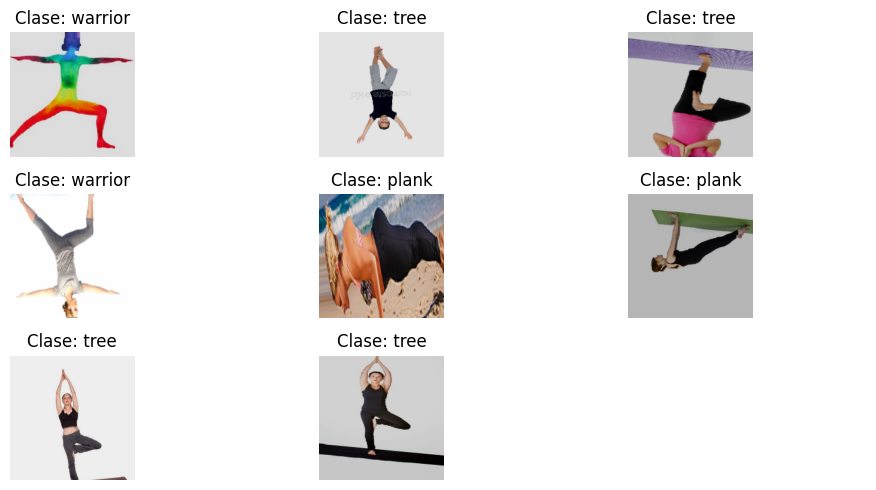

In [8]:
# Obtener un lote de imágenes y etiquetas del generador de datos
images, labels = next(train_data)

# Etiquetas de las clases (nombre de las carpetas)
class_labels = list(train_data.class_indices.keys())
print(class_labels)
# Configurar subplots
num_images = 8
num_cols = 3 # Número de columnas en la cuadrícula
num_rows = (num_images + num_cols - 1) // num_cols  # Calcular el número de filas necesarias

# Crear una cuadrícula de subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 5))

# Iterar a través de las imágenes y subplots
for i, ax in enumerate(axes.flatten()):
    if i < num_images:
        image = images[i]
        label = class_labels[int(labels[i])]
        
        ax.imshow(image)
        ax.set_title(f"Clase: {label}")
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()


## Defining our models

In [9]:
class ImprovedTransferNetVGG19(models.Model):
    def __init__(self, base_model_weights=None):
        super(ImprovedTransferNetVGG19, self).__init__()
        self.base_model = tf.keras.applications.VGG19(include_top=False, weights=base_model_weights, input_shape=(224, 224, 3))
        for layer in self.base_model.layers:
            layer.trainable = False  # Freeze VGG19 layers initially
        self.flatten = layers.Flatten()
        
        l1lambda = 0.0001
        # Dense layers with reduced neurons
        self.fc1 = layers.Dense(1024, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(l1lambda))
        self.fc1_bn = layers.BatchNormalization()
        self.fc1_dropout = layers.Dropout(0.3)

        self.fc2 = layers.Dense(512, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(l1lambda))
        self.fc2_bn = layers.BatchNormalization()
        self.fc2_dropout = layers.Dropout(0.4)
        
        self.fc3 = layers.Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(l1lambda))
        self.fc3_bn = layers.BatchNormalization()
        self.fc3_dropout = layers.Dropout(0.5)

        self.fc4 = layers.Dense(4, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(l1lambda))

    def call(self, x):
        x = self.base_model(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc1_bn(x)
        x = self.fc1_dropout(x)
        
        x = self.fc2(x)
        x = self.fc2_bn(x)
        x = self.fc2_dropout(x)

        x = self.fc3(x)
        x = self.fc3_bn(x)
        x = self.fc3_dropout(x)

        x = self.fc4(x)
        return x
    def unfreeze_last_layers(self, num_layers=6):
        """Desbloquea las últimas num_layers del modelo base."""
        for layer in self.base_model.layers[-num_layers:]:
            layer.trainable = True

    def get_config(self):
        return {"base_model_name": "VGG19"}

    @classmethod
    def from_config(cls, config):
        if config["base_model_name"] == "VGG19":
            return cls(base_model_weights="imagenet")


In [10]:

model = ImprovedTransferNetVGG19(base_model_weights='imagenet')


In [11]:

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.00011887582580825929)
EPOCHS=30

In [12]:
#learning rate schedulling
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)


In [13]:
model.compile(optimizer=optimizer, 
              loss=SparseCategoricalCrossentropy(), 
              metrics=['accuracy'])

In [14]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=0, restore_best_weights=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint('checkpoint', monitor='val_loss', verbose=0, save_best_only=True)


In [15]:
STEP_SIZE_TRAIN=train_data.n//train_data.batch_size
STEP_SIZE_VALID=validation_data.n//validation_data.batch_size
STEP_SIZE_TEST=test_data.n//test_data.batch_size
STEP_SIZE_TRAIN

199

In [16]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
callbacks = [early_stopping, checkpoint,lr_schedule]


In [17]:
callbacks = [early_stopping, checkpoint,lr_schedule, tensorboard_callback]
history =model.fit(train_data,
    validation_data=validation_data,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/30
200/200 [==============================] - ETA: 0s - loss: 4.0773 - accuracy: 0.5142INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


200/200 [==============================] - 641s 3s/step - loss: 4.0773 - accuracy: 0.5142 - val_loss: 2.8336 - val_accuracy: 0.6988 - lr: 1.1888e-04
Epoch 2/30
149/200 [=====================>........] - ETA: 2:31 - loss: 3.0431 - accuracy: 0.5949

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs_loss_train = range(1,len(loss_train)+1)
epochs_loss_val = range(1,len(loss_val)+1)
plt.plot(epochs_loss_train, loss_train, 'g', label='Training loss')
plt.plot(epochs_loss_val, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('training.png')
plt.show()

plt.figure()
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs_loss_train = range(1,len(loss_train)+1)
epochs_loss_val = range(1,len(loss_val)+1)
plt.plot(epochs_loss_train, loss_train, 'g', label='Training accuracy')
plt.plot(epochs_loss_val, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('accuracy.png')
plt.show()


In [ ]:
model.summary()

In [ ]:
model.save_weights('vgg19.h5')

### Resultados del modelo

In [ ]:
# Obtener las predicciones del modelo
predictions = model.predict(test_data)
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las etiquetas verdaderas
true_classes = test_data.classes
class_labels = list(test_data.class_indices.keys())

# Calcular la matriz de confusión
confusion = confusion_matrix(true_classes, predicted_classes)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# 1. Predice las etiquetas de tus datos de prueba.
predictions = model.predict(test_data)
predicted_classes = np.argmax(predictions, axis=1)

# 2. Obtén las etiquetas verdaderas de tus datos de prueba.
true_classes = test_data.classes
class_labels = list(test_data.class_indices.keys())

# 3. Usa `classification_report` para obtener el informe.
report = classification_report(true_classes, predicted_classes, target_names=class_labels,zero_division=1)
print(report)


## Fine tuning

In [ ]:
model.unfreeze_last_layers(num_layers=6)

# Compilar el modelo con un learning rate muy bajo
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-5)  # Usa una tasa de aprendizaje más baja
model.compile(optimizer=optimizer, 
              loss=SparseCategoricalCrossentropy(), 
              metrics=['accuracy'])

# Continuar el entrenamiento
history =model.fit(train_data,
        steps_per_epoch=STEP_SIZE_TRAIN,
        validation_data=validation_data,
        validation_steps=STEP_SIZE_VALID,
        epochs=20,
        callbacks=callbacks
)

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,10+1)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
    
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,10+1)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



In [ ]:
# 1. Predice las etiquetas de tus datos de prueba.
predictions = model.predict(test_data)
predicted_classes = np.argmax(predictions, axis=1)

# 2. Obtén las etiquetas verdaderas de tus datos de prueba.
true_classes = test_data.classes
class_labels = list(test_data.class_indices.keys())

# 3. Usa `classification_report` para obtener el informe.
report = classification_report(true_classes, predicted_classes, target_names=class_labels,zero_division=1)
print(report)


In [ ]:
# Obtener las predicciones del modelo
predictions = model.predict(test_data)
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las etiquetas verdaderas
true_classes = test_data.classes
class_labels = list(test_data.class_indices.keys())

# Calcular la matriz de confusión
confusion = confusion_matrix(true_classes, predicted_classes)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
model.save_weights('vgg19_FT.h5')

In [ ]:
model.summary()
